In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joeprickett","key":"1568083b2d1930885bee88cd8ebd901e"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600  ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 610M/612M [00:28<00:00, 22.8MB/s]
100% 612M/612M [00:28<00:00, 22.6MB/s]


In [7]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [8]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
img_height = 32
img_width = 32
batch_size = 32

In [10]:
data = []
labels = []
classes = 43

with tf.device('/GPU:0'):
  for i in range(classes):
      path = os.path.join('/content/Train',str(i))
      images = os.listdir(path)

      for image in images:
        image = Image.open(os.path.join(path, image))
        image = image.resize((img_height,img_width))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((31367, 32, 32, 3), (31367,))

In [13]:
X_val.shape, y_val.shape

((7842, 32, 32, 3), (7842,))

In [15]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.10), # Don't want to do too extreme rotation and want to avoid flipping
        tf.keras.layers.RandomZoom(0.15),
        tf.keras.layers.RandomHeight(0.05),
        tf.keras.layers.RandomWidth(0.05),
        tf.keras.layers.RandomBrightness([0,0.2]),
        tf.keras.layers.Resizing(img_height, img_width),
        tf.keras.layers.Rescaling(1./255)
     
    ]
)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 256)       295168    
                                                      

In [18]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [20]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint_callback])

Epoch 1/50
981/981 [==============================] - 23s 11ms/step - loss: 2.1936 - accuracy: 0.3502 - val_loss: 0.8228 - val_accuracy: 0.7183
Epoch 2/50
981/981 [==============================] - 9s 9ms/step - loss: 0.7571 - accuracy: 0.7537 - val_loss: 0.1960 - val_accuracy: 0.9464
Epoch 3/50
981/981 [==============================] - 9s 9ms/step - loss: 0.3578 - accuracy: 0.8862 - val_loss: 0.0870 - val_accuracy: 0.9746
Epoch 4/50
981/981 [==============================] - 9s 9ms/step - loss: 0.2434 - accuracy: 0.9271 - val_loss: 0.0528 - val_accuracy: 0.9842
Epoch 5/50
981/981 [==============================] - 9s 9ms/step - loss: 0.1876 - accuracy: 0.9443 - val_loss: 0.0408 - val_accuracy: 0.9867
Epoch 6/50
981/981 [==============================] - 10s 10ms/step - loss: 0.1603 - accuracy: 0.9509 - val_loss: 0.0417 - val_accuracy: 0.9861
Epoch 7/50
981/981 [==============================] - 9s 9ms/step - loss: 0.1374 - accuracy: 0.9594 - val_loss: 0.0472 - val_accuracy: 0.9878
Ep

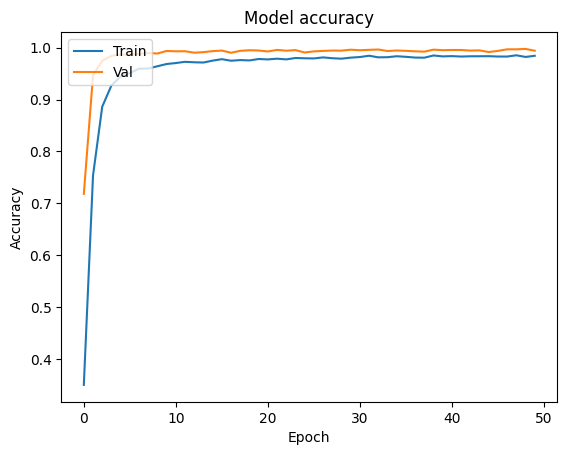

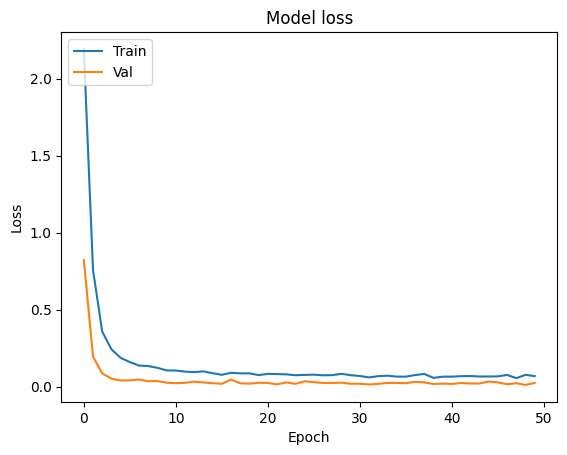

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [22]:
test = pd.read_csv('/content/Test.csv')

y_test = test["ClassId"].values
imgs = test["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test=np.array(data)

In [23]:
model = tf.keras.models.load_model('best_model.h5')

In [24]:
# X_test = X_test/255
model_predict = model.predict(X_test)

correct_predict = []
incorrect_predict = []

for i in range(len(model_predict)):
  label = np.argmax(model_predict[i])
  if label == y_test[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

Accuracy = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('Accuracy: {}'.format(Accuracy))

395/395 [==============================] - 1s 3ms/step
accuracay: 0.9699920823436263
